In [256]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import svd

## 1. Dimension reduction using pricipal component analysis(PCA)

### 1.1 Using Singular-Value Decompositiom (SVD) method, please decpompose 1st and 2nd pricipal components and project them to the data

In [257]:
# read data 
data = pd.read_csv('fashion_mnist1.csv')

In [258]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,2,...,116,30,0,0,0,0,1,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,6,...,18,0,0,0,0,0,0,0,0,0


In [259]:
data.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
9995,0,0,0,0,0,0,0,0,0,0,...,132,103,78,77,0,0,2,0,0,0
9996,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,2,0,0,0,0,0,0,1,0,0,...,229,217,231,137,0,0,0,0,0,0
9999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
# separate lables and features
labels = data['label']
features = data.drop(columns=['label'])

In [261]:
# perform SVD
U, S, Vt = svd(features, full_matrices=False)

In [262]:
# project data onto the first and second principal components
projected_data = np.dot(U[:, :2], np.diag(S[:2]))

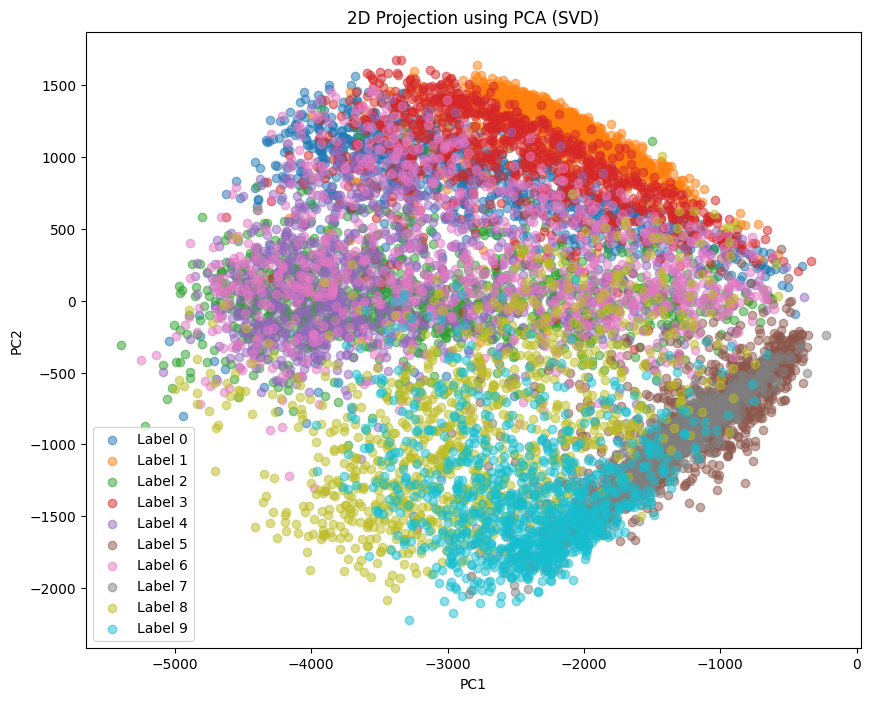

In [263]:

# plot the results with different colors for labels
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(projected_data[idx, 0], projected_data[idx, 1], label=f'Label {label}', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('2D Projection using PCA (SVD)')
plt.show()

### 1.2 As we discussed during the class, we can compress images using PCA

In [264]:
# select 10 images, one from each label
selected_images = []
for label in np.unique(labels):
    selected_images.append(features[labels == label].iloc[0].values)
selected_images = np.array(selected_images)

In [265]:
# function to compress images using PCA
def compress_image(image, k):
    U, S, Vt = svd(image.reshape(28, 28), full_matrices=False)
    compressed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    return compressed

In [266]:
# visualize original and compressed images for different k
k_values = [2, 5, 10]
num_images = len(selected_images)

plt.figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

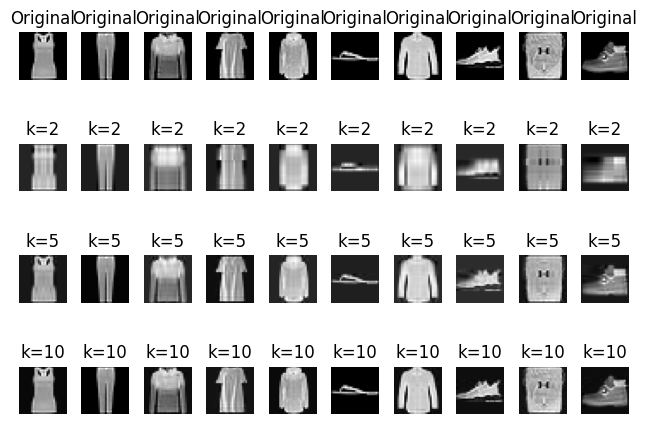

In [267]:
# Loop over the images
for i, img in enumerate(selected_images):
    # Plot the original image
    plt.subplot(4, num_images, i+1)  # Changed 3 rows to 4 rows to avoid the out-of-bounds issue
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')  # Turn off axis for clarity

    # Plot the compressed images for different values of k
    for j, k in enumerate(k_values):
        compressed_img = compress_image(img, k)
        plt.subplot(4, num_images, (j+1)*num_images + i+1)
        plt.imshow(compressed_img, cmap='gray')
        plt.title(f'k={k}')
        plt.axis('off')  # Turn off axis for clarity

plt.tight_layout()
plt.show()

## 2.Dimension reduction using t-SNE

### 2.1 Please build t-SNE algorithm from scratch bases on the below equations

In [268]:
# assuming 'data' is your DataFrame, and 'label' is the name of the column with labels.
features = data.drop(columns=['label'])  # replace 'label' with the name of the actual label column
labels = data['label']  # the column containing the labels


In [269]:
# function compute pairwise
def compute_pairwise_affinities(X, perplexity=30, tol=1e-5, max_iter=50):
    # compute pairwise affinities P_ij using Gaussian kernel based on the perplexity.
    
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), axis=1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)  # squared Euclidean distances

    epsilon = 1e-8
    D = np.maximum(D, epsilon)  # avoid zero distances for stability
    
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    log_perplexity = np.log(perplexity)

    def h_beta(Di, beta):
        P = np.exp(-Di * beta)
        sum_P = np.sum(P)
        
        # ensure we don't take log of zero or divide by zero
        if sum_P == 0:
            sum_P = epsilon
        
        H = np.log(sum_P) + beta * np.sum(Di * P) / sum_P
        P = P / sum_P
        return H, P

    for i in range(n):
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = h_beta(Di, beta[i])
        Hdiff = H - log_perplexity
        tries = 0
        
        while np.abs(Hdiff) > tol and tries < max_iter:
            if Hdiff > 0:
                beta[i] *= 2
            else:
                beta[i] /= 2
            H, thisP = h_beta(Di, beta[i])
            Hdiff = H - log_perplexity
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    P = (P + P.T) / (2 * n)  # symmetrize P and normalize
    return np.maximum(P, epsilon)  # avoid zero probabilities


In [270]:
# function compute low dimensional
def compute_low_dim_affinities(Y):
    # compute low-dimensional affinities q_ij using the Student-t distribution.
    n = Y.shape[0]
    sum_Y = np.sum(np.square(Y), axis=1)
    D = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
    
    Q = 1 / (1 + D)
    np.fill_diagonal(Q, 0)  # avoid self-affinities
    Q = Q / np.sum(Q)  # normalize Q
    return np.maximum(Q, 1e-12)  # avoid division by zero


In [271]:
# function Kl_divergence
def kl_divergence(P, Q, Y):
    # Compute the gradient of KL divergence with respect to Y.
    n = P.shape[0]
    dY = np.zeros_like(Y)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                dY[i, :] += (P[i, j] - Q[i, j]) * (Y[i, :] - Y[j, :]) / (1 + np.sum(np.square(Y[i, :] - Y[j, :])))
    
    return dY


In [272]:
# fucntion t-SNE
def tsne(X, perplexity=30, learning_rate=200, n_iter=1000, momentum=0.5, n_components=2):
    # run t-SNE on dataset X.
    (n, d) = X.shape
    Y = np.random.randn(n, n_components)  # random initialization of Y
    dY_prev = np.zeros_like(Y)  # for momentum
    
    P = compute_pairwise_affinities(X, perplexity)  # high-dimensional affinities
    
    for iter in range(n_iter):
        Q = compute_low_dim_affinities(Y)  # low-dimensional affinities
        dY = kl_divergence(P, Q, Y)  # gradient of KL divergence
        
        # update Y using gradient descent with momentum
        Y = Y - learning_rate * dY + momentum * dY_prev
        dY_prev = dY
        
        # optionally, print progress every 100 iterations
        if iter % 100 == 0:
            print(f"Iteration {iter}: KL divergence = {np.sum(P * np.log(P / Q))}")
    
    return Y


/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 0.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.595064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.094727
[t-SNE] KL divergence after 300 iterations: 2.416071


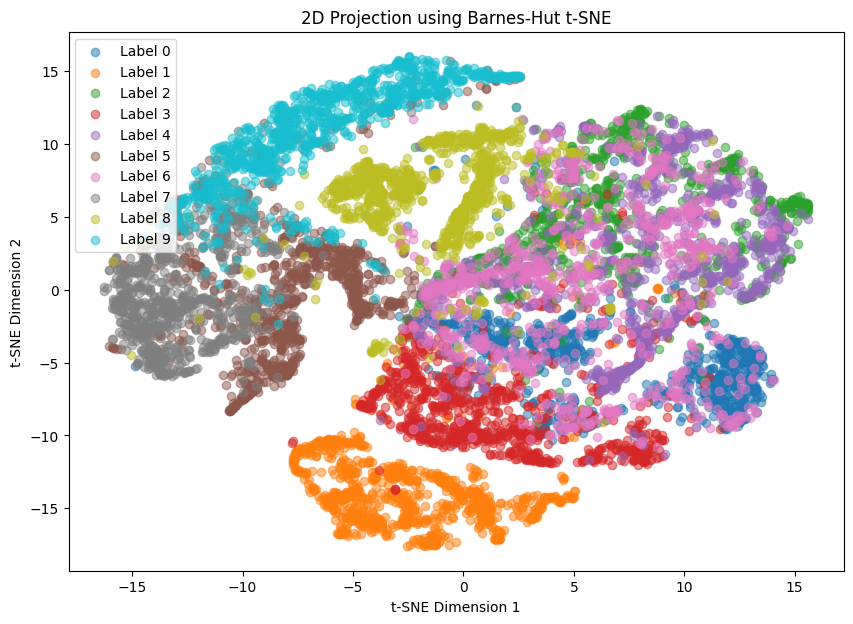

In [273]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.values)

# use Barnes-Hut t-SNE for faster performance
tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, learning_rate=500, method='barnes_hut', verbose=1)
reduced_data = tsne_model.fit_transform(scaled_features)

# plot the results with different colors for labels
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=f'Label {label}', alpha=0.5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('2D Projection using Barnes-Hut t-SNE')
plt.show()


### 2.2 Using the t-SNE method, please reduce the 784 dimensions to 2 dimensions.

In [274]:
from sklearn.cluster import KMeans

# Function to calculate D and J
def calculate_D_J(reduced_data, labels):
    # Step 1: Calculate centroids for each of the 10 labels
    centroids = []
    for label in np.unique(labels):
        centroid = reduced_data[labels == label].mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)

    # Step 2: Calculate D (sum of squared distances between centroids)
    D = 0
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            D += np.sum((centroids[i] - centroids[j]) ** 2)

    # Step 3: Calculate J (sum of squared distances from points to their centroids)
    J = 0
    for label in np.unique(labels):
        points = reduced_data[labels == label]
        centroid = centroids[label]
        J += np.sum((points - centroid) ** 2)
    
    return D, J

In [275]:
# Hyperparameter settings for t-SNE
hyperparameters = [
    {'perplexity': 30, 'learning_rate': 200, 'n_iter': 300},
    {'perplexity': 50, 'learning_rate': 300, 'n_iter': 300},
    {'perplexity': 20, 'learning_rate': 100, 'n_iter': 400},
    {'perplexity': 40, 'learning_rate': 500, 'n_iter': 250},
    {'perplexity': 10, 'learning_rate': 150, 'n_iter': 350},
]

Running t-SNE with hyperparameters: {'perplexity': 30, 'learning_rate': 200, 'n_iter': 300}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.017s...


/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.829s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.595064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.065979
[t-SNE] KL divergence after 300 iterations: 2.752674
Hyperparameters 1: D = 4165.36962890625, J = 138203.53125
Running t-SNE with hyperparameters: {'perplexity': 50

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.843s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 6.104873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.295959
[t-SNE] KL divergence after 300 iterations: 2.257622
Hyperparameters 2: D = 5466.78662109375, J = 179660.25
Running t-SNE with hyperparameters: {'perplexity': 20, '

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.856s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.198704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.996964
[t-SNE] KL divergence after 400 iterations: 2.477285
Hyperparameters 3: D = 15204.7333984375, J = 511657.3125
Running t-SNE with hyperparameters: {'perplexity': 40,

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.970s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.879536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.963791
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.882s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.501999
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.939636
[t-SNE] KL divergence after 350 iterations: 3.022432
Hyperparameters 5: D = 12483.1787109375, J = 415522.875


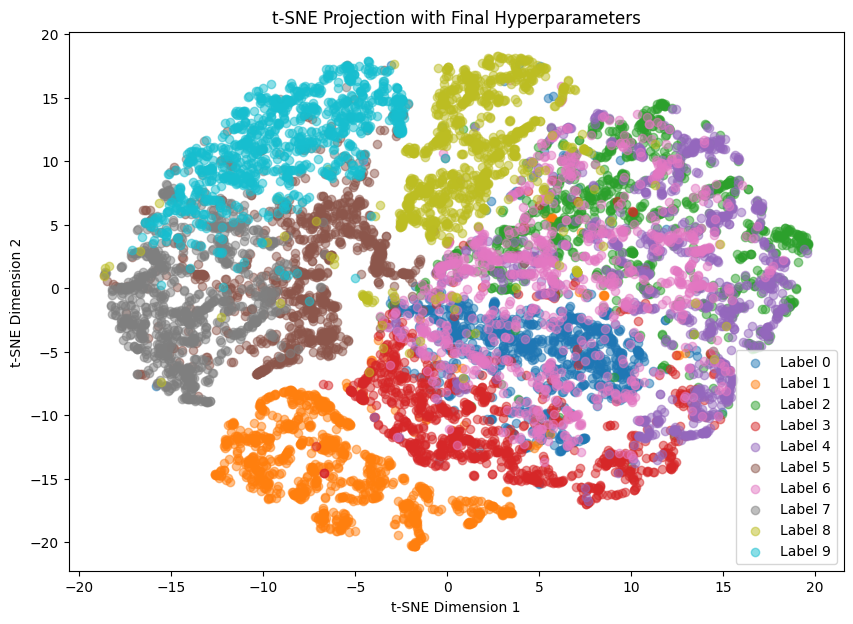

In [276]:
# loop over the different hyperparameter settings
results = []
for i, params in enumerate(hyperparameters):
    print(f"Running t-SNE with hyperparameters: {params}")
    
    # run t-SNE with the current set of hyperparameters
    tsne_model = TSNE(n_components=2, perplexity=params['perplexity'], 
                      learning_rate=params['learning_rate'], n_iter=params['n_iter'], method='barnes_hut', verbose=1)
    
    reduced_data = tsne_model.fit_transform(scaled_features)

    # calculate D and J for the current reduced data
    D, J = calculate_D_J(reduced_data, labels)
    results.append({'hyperparameters': params, 'D': D, 'J': J})
    
    print(f"Hyperparameters {i + 1}: D = {D}, J = {J}")
    
 # plot viisualizing the last t-SNE result
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=f'Label {label}', alpha=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('t-SNE Projection with Final Hyperparameters')
plt.show()

### 2.3 Please draw 2D plot for the 5 hyperparameter conditions.
###     Please legend different colors for the 10 labels in the graph.

Running t-SNE with hyperparameters: {'perplexity': 30, 'learning_rate': 200, 'n_iter': 300}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.023s...


/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.595064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.065796
[t-SNE] KL divergence after 300 iterations: 2.752646
Running t-SNE with hyperparameters: {'perplexity': 50, 'learning_rate': 300, 'n_iter': 300}
[t-SNE] Computing 1

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 6.104873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.295959
[t-SNE] KL divergence after 300 iterations: 2.257588
Running t-SNE with hyperparameters: {'perplexity': 20, 'learning_rate': 100, 'n_iter': 400}
[t-SNE] Computing 6

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.852s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.198704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.996071
[t-SNE] KL divergence after 400 iterations: 2.476769
Running t-SNE with hyperparameters: {'perplexity': 40, 'learning_rate': 500, 'n_iter': 250}
[t-SNE] Computing 1

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.890s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.879536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.965347
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.787s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.501999
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.943695
[t-SNE] KL divergence after 350 iterations: 3.022770


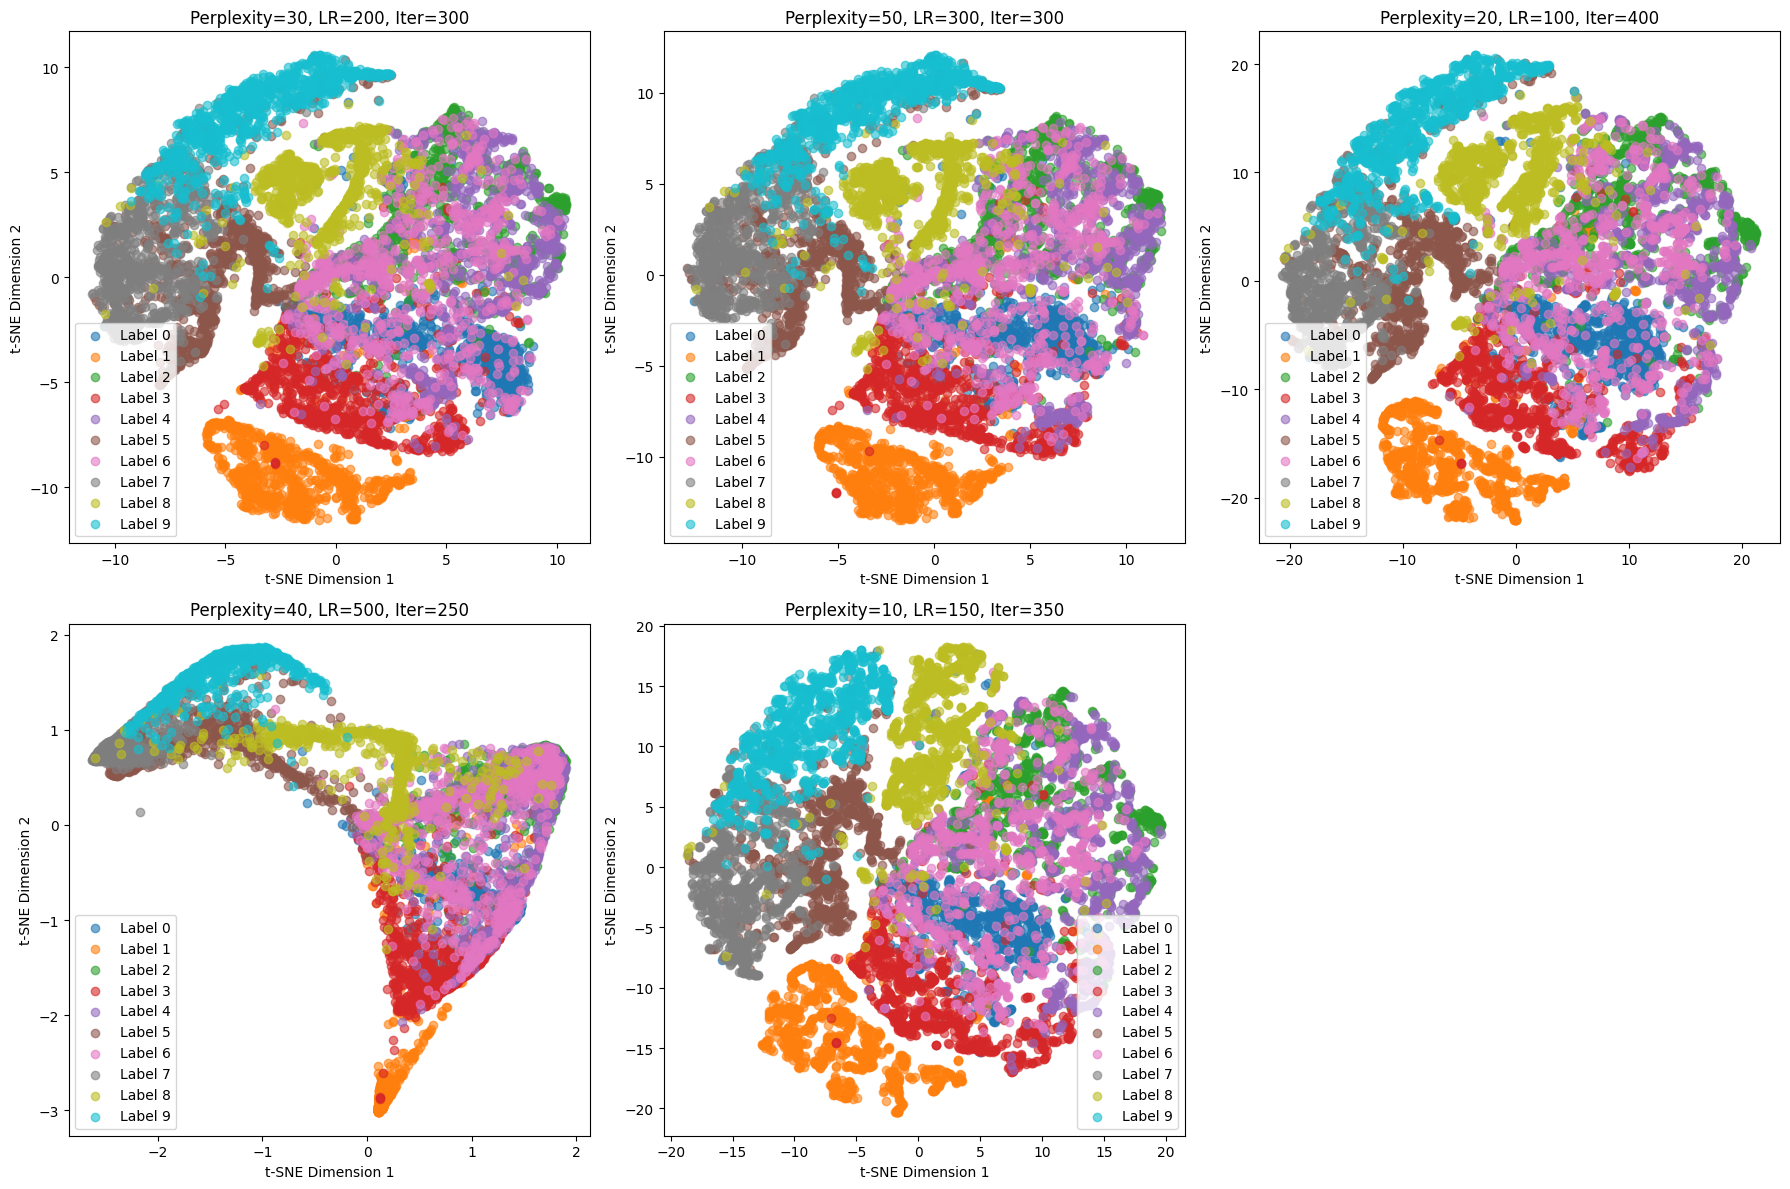

In [277]:
# create subplots to display all 5 t-SNE results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()  # flatten the axes array for easier indexing

# loop over the different hyperparameter settings and plot
for i, params in enumerate(hyperparameters):
    print(f"Running t-SNE with hyperparameters: {params}")
    
    # run t-SNE with the current hyperparameters
    tsne_model = TSNE(n_components=2, perplexity=params['perplexity'], 
                      learning_rate=params['learning_rate'], n_iter=params['n_iter'], method='barnes_hut', verbose=1)
    
    reduced_data = tsne_model.fit_transform(scaled_features)

    # plot the 2D projection for this hyperparameter setting
    ax = axes[i]
    for label in np.unique(labels):
        idx = labels == label
        ax.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=f'Label {label}', alpha=0.6)
    
    ax.set_title(f"Perplexity={params['perplexity']}, LR={params['learning_rate']}, Iter={params['n_iter']}")
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.legend()

# remove the last unused subplot if we have less than 6
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()
